In [1]:
# A. Import Basic Libraries

from collections import OrderedDict

# Libraries for analysis
import pandas as pd
import numpy as np
from sklearn import svm
import csv
import copy
import datetime

# Libraries for visuals
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)

In [2]:
# B. Import Data

#2010-2012
survey_trips_full = pd.read_csv('desktop/Caltrans/California_Household_Travel_Survey_2010_2012/caltrans_full_survey/survey_activity.csv', encoding = "ISO-8859-1", low_memory=False)
survey_households_full = pd.read_csv('desktop/Caltrans/California_Household_Travel_Survey_2010_2012/caltrans_full_survey/survey_households.csv', encoding = "ISO-8859-1", low_memory=False)
survey_person_full = pd.read_csv('desktop/Caltrans/California_Household_Travel_Survey_2010_2012/caltrans_full_survey/survey_person.csv', encoding = "ISO-8859-1", low_memory=False)
survey_place_full = pd.read_csv('desktop/Caltrans/California_Household_Travel_Survey_2010_2012/caltrans_full_survey/survey_place.csv', encoding = "ISO-8859-1", low_memory=False)
survey_vehicles_full = pd.read_csv('desktop/Caltrans/California_Household_Travel_Survey_2010_2012/caltrans_full_survey/survey_vehicles.csv', encoding = "ISO-8859-1", low_memory=False)




In [3]:
# C. Get Data in Right Form

# get only the columns needed from each data set
survey_trips_working = survey_trips_full[['sampno', 'perno', 'purpose', 'arr_time', 'dep_time', 'travel_date', 'county_id', 
                                          'zipcode']]
working = survey_trips_working.copy(deep=True)
working_ = working[0:10]

survey_households_working = survey_households_full[['sampno', 'home_county_id', 'home_zipcode',
                                                    'vehicle_count', 'persons_count', 'worker_count', 'student_count',
                                                    'income', 'residence_type', 'home_own']]

survey_person_working = survey_person_full[['sampno', 'perno', 'vehno', 'gender', 'education', 'race1',
                                           'empl_status', 'empl_industry', 'employment', 'empl_occupation',
                                            'student', 'school_zipcode']]

survey_vehicles_working = survey_vehicles_full[['sampno', 'vehno', 'veh_type', 'model_year', 'veh_make', 'body_type', 'fuel_type1', 'purchase_type', 'ownership']]



In [4]:
# fix time and date for survey_trips_working

#check if isdate time object o
isinstance(working_.dep_time.dtypes, datetime.datetime)



False

In [5]:
#make copy for testing
w = working_.copy(deep=True)
w


,sampno,perno,purpose,arr_time,dep_time,travel_date,county_id,zipcode
0,1039879,1,1,3:00:00,8:00:00,6/24/12,19.0,93702
1,1041766,3,1,3:00:00,8:00:00,5/1/12,81.0,94030
2,1043722,2,1,18:50:00,2:59:00,7/3/12,107.0,93618
3,1050668,1,4,8:00:00,8:30:00,5/4/12,111.0,91360
4,1051203,1,1,18:16:00,2:59:00,5/7/12,75.0,94102
5,1055989,2,1,3:00:00,6:30:00,5/24/12,77.0,95330
6,1058112,1,1,3:00:00,19:40:00,8/3/12,77.0,95215
7,1063648,2,1,4:13:00,12:00:00,5/31/12,7.0,95928
8,1065929,1,1,3:00:00,6:30:00,5/1/12,1.0,94610
9,1067135,1,2,10:30:00,12:00:00,5/12/12,87.0,95062


In [6]:
#make copy for testing
w = working_.copy(deep=True)
w

w.travel_date = pd.to_datetime(w.travel_date, format='%m/%d/%y').dt.weekday_name
w['arrival_hour'] = pd.to_datetime(w.arr_time, format='%H:%M:%S').dt.hour
w['arrival_minute'] = pd.to_datetime(w.arr_time, format='%H:%M:%S').dt.minute


w.head()

,sampno,perno,purpose,arr_time,dep_time,travel_date,county_id,zipcode,arrival_hour,arrival_minute
0,1039879,1,1,3:00:00,8:00:00,Sunday,19.0,93702,3,0
1,1041766,3,1,3:00:00,8:00:00,Tuesday,81.0,94030,3,0
2,1043722,2,1,18:50:00,2:59:00,Tuesday,107.0,93618,18,50
3,1050668,1,4,8:00:00,8:30:00,Friday,111.0,91360,8,0
4,1051203,1,1,18:16:00,2:59:00,Monday,75.0,94102,18,16


In [7]:
def series_day_to_num(df):
    
    '''Function that takes a DataFrame with dateTime object
    and builds a Series in the same order with the day as
    the corresponding number
    0-Sun, 1-Mon, 2-Tues, 3-Wed, 4-Thur, 5-Fri, 6-Sat'''
    
    dic = OrderedDict()
    key=0
    
    for i, row in df.iterrows():
        if row[0] == "Sunday":
            day_num = 0
        elif row[0] == "Monday":
            day_num = 1
        elif row[0] == "Tuesday":
            day_num = 2
        elif row[0] == "Wednesday":
            day_num = 3
        elif row[0] == "Thursday":
            day_num = 4
        elif row[0] == "Friday":
            day_num = 5
        elif row[0] == "Saturday":
            day_num = 6
            
        dic[key] = day_num   
        key += 1
        
    new_series = pd.Series(dic)
    return new_series
    

In [8]:
#Join all the datasets into one
working1 = pd.merge(survey_trips_working, survey_person_working, on=['sampno', 'perno'])
working2 = pd.merge(working1, survey_vehicles_working, on=['sampno', 'vehno'])
working3 = pd.merge(working2, survey_households_working, on=['sampno'])

working3



,sampno,perno,purpose,arr_time,dep_time,travel_date,county_id,zipcode,vehno,gender,...,ownership,home_county_id,home_zipcode,vehicle_count,persons_count,worker_count,student_count,income,residence_type,home_own
0,1050668,1,4,8:00:00,8:30:00,5/4/12,111.0,91360,1.0,1,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
1,1050668,1,9,8:45:00,14:55:00,5/4/12,111.0,91360,1.0,1,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
2,1050668,1,11,11:30:00,12:00:00,5/4/12,111.0,91360,1.0,1,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
3,1050668,1,1,15:00:00,2:59:00,5/4/12,111.0,91360,1.0,1,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
4,1050668,1,1,5:30:00,7:30:00,5/4/12,111.0,91360,1.0,1,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
5,1050668,1,2,7:30:00,8:00:00,5/4/12,111.0,91360,1.0,1,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
6,1050668,2,1,3:00:00,7:30:00,5/4/12,111.0,91360,2.0,2,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
7,1050668,2,2,7:30:00,8:00:00,5/4/12,111.0,91360,2.0,2,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
8,1050668,2,4,8:00:00,8:30:00,5/4/12,111.0,91360,2.0,2,...,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0
9,1055989,2,1,3:00:00,6:30:00,5/24/12,77.0,95330,2.0,1,...,1,77.0,95330.0,2.0,2.0,0.0,0.0,7.0,1.0,1.0


In [9]:
#make a copy as a checkpoint
working_trips = working3.copy(deep=True)
working_trips

#change travel_data column to day of the week
working_trips.travel_date = pd.to_datetime(working_trips.travel_date, format='%m/%d/%y').dt.weekday_name

#get hour and minute of arrival and departure and make new colums
working_trips['arrival_hour'] = pd.to_datetime(working_trips.arr_time, format='%H:%M:%S').dt.hour
working_trips['arrival_minute'] = pd.to_datetime(working_trips.arr_time, format='%H:%M:%S').dt.minute

working_trips['departure_hour'] = pd.to_datetime(working_trips.dep_time, format='%H:%M:%S').dt.hour
working_trips['departure_minute'] = pd.to_datetime(working_trips.dep_time, format='%H:%M:%S').dt.minute

working_trips.head(n=10)


,sampno,perno,purpose,arr_time,dep_time,travel_date,county_id,zipcode,vehno,gender,...,persons_count,worker_count,student_count,income,residence_type,home_own,arrival_hour,arrival_minute,departure_hour,departure_minute
0,1050668,1,4,8:00:00,8:30:00,Friday,111.0,91360,1.0,1,...,2.0,1.0,0.0,10.0,1.0,1.0,8,0,8,30
1,1050668,1,9,8:45:00,14:55:00,Friday,111.0,91360,1.0,1,...,2.0,1.0,0.0,10.0,1.0,1.0,8,45,14,55
2,1050668,1,11,11:30:00,12:00:00,Friday,111.0,91360,1.0,1,...,2.0,1.0,0.0,10.0,1.0,1.0,11,30,12,0
3,1050668,1,1,15:00:00,2:59:00,Friday,111.0,91360,1.0,1,...,2.0,1.0,0.0,10.0,1.0,1.0,15,0,2,59
4,1050668,1,1,5:30:00,7:30:00,Friday,111.0,91360,1.0,1,...,2.0,1.0,0.0,10.0,1.0,1.0,5,30,7,30
5,1050668,1,2,7:30:00,8:00:00,Friday,111.0,91360,1.0,1,...,2.0,1.0,0.0,10.0,1.0,1.0,7,30,8,0
6,1050668,2,1,3:00:00,7:30:00,Friday,111.0,91360,2.0,2,...,2.0,1.0,0.0,10.0,1.0,1.0,3,0,7,30
7,1050668,2,2,7:30:00,8:00:00,Friday,111.0,91360,2.0,2,...,2.0,1.0,0.0,10.0,1.0,1.0,7,30,8,0
8,1050668,2,4,8:00:00,8:30:00,Friday,111.0,91360,2.0,2,...,2.0,1.0,0.0,10.0,1.0,1.0,8,0,8,30
9,1055989,2,1,3:00:00,6:30:00,Thursday,77.0,95330,2.0,1,...,2.0,0.0,0.0,7.0,1.0,1.0,3,0,6,30


In [10]:
#now change travel_date column from string to corresponding int
Series_travel_day = working_trips[['travel_date']]
num_travel_day = series_day_to_num(Series_travel_day)
num_travel_day.head(n=10)

0    5
1    5
2    5
3    5
4    5
5    5
6    5
7    5
8    5
9    4
dtype: int64

In [36]:
#make another copy as a checkpoint
working_trips_f = working_trips.copy(deep=True)

#turn num_travel_day (Series into DataFrame for easy joining)
DF_num_travel_day = num_travel_day.to_frame()
DF_num_travel_day.columns = ['travel_day_of_week']

#add column to the data frame
df_concat = pd.concat([working_trips_f, DF_num_travel_day], axis=1)
df_concat 

#drop old columns that aren't dateTime objects
df_concat.drop(columns=['dep_time', 'arr_time', 'travel_date'], axis=1,  inplace=True)

#so i can see all columns in the DataFrame without truncation
pd.set_option('display.max_columns', 500)
df_concat

,sampno,perno,purpose,county_id,zipcode,vehno,gender,education,race1,empl_status,empl_industry,employment,empl_occupation,student,school_zipcode,veh_type,model_year,veh_make,body_type,fuel_type1,purchase_type,ownership,home_county_id,home_zipcode,vehicle_count,persons_count,worker_count,student_count,income,residence_type,home_own,arrival_hour,arrival_minute,departure_hour,departure_minute,travel_day_of_week
0,1050668,1,4,111.0,91360,1.0,1,5,1.0,NaN,31.0,1.0,11.0,3,NaN,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,8,0,8,30,5
1,1050668,1,9,111.0,91360,1.0,1,5,1.0,NaN,31.0,1.0,11.0,3,NaN,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,8,45,14,55,5
2,1050668,1,11,111.0,91360,1.0,1,5,1.0,NaN,31.0,1.0,11.0,3,NaN,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,11,30,12,0,5
3,1050668,1,1,111.0,91360,1.0,1,5,1.0,NaN,31.0,1.0,11.0,3,NaN,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,15,0,2,59,5
4,1050668,1,1,111.0,91360,1.0,1,5,1.0,NaN,31.0,1.0,11.0,3,NaN,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,5,30,7,30,5
5,1050668,1,2,111.0,91360,1.0,1,5,1.0,NaN,31.0,1.0,11.0,3,NaN,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,7,30,8,0,5
6,1050668,2,1,111.0,91360,2.0,2,6,1.0,1.0,NaN,2.0,NaN,3,NaN,2,2001,13,2,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,3,0,7,30,5
7,1050668,2,2,111.0,91360,2.0,2,6,1.0,1.0,NaN,2.0,NaN,3,NaN,2,2001,13,2,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,7,30,8,0,5
8,1050668,2,4,111.0,91360,2.0,2,6,1.0,1.0,NaN,2.0,NaN,3,NaN,2,2001,13,2,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,8,0,8,30,5
9,1055989,2,1,77.0,95330,2.0,1,1,97.0,1.0,NaN,2.0,NaN,3,NaN,2,2001,35,3,1.0,1,1,77.0,95330.0,2.0,2.0,0.0,0.0,7.0,1.0,1.0,3,0,6,30,4


In [ ]:
# --------------------------------------------------

In [38]:
#Have to get rid of all NANs in data (only occur in X)
df_concat = df_concat.fillna(10000)
df_concat

,sampno,perno,purpose,county_id,zipcode,vehno,gender,education,race1,empl_status,empl_industry,employment,empl_occupation,student,school_zipcode,veh_type,model_year,veh_make,body_type,fuel_type1,purchase_type,ownership,home_county_id,home_zipcode,vehicle_count,persons_count,worker_count,student_count,income,residence_type,home_own,arrival_hour,arrival_minute,departure_hour,departure_minute,travel_day_of_week
0,1050668,1,4,111.0,91360,1.0,1,5,1.0,10000.0,31.0,1.0,11.0,3,10000,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,8,0,8,30,5
1,1050668,1,9,111.0,91360,1.0,1,5,1.0,10000.0,31.0,1.0,11.0,3,10000,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,8,45,14,55,5
2,1050668,1,11,111.0,91360,1.0,1,5,1.0,10000.0,31.0,1.0,11.0,3,10000,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,11,30,12,0,5
3,1050668,1,1,111.0,91360,1.0,1,5,1.0,10000.0,31.0,1.0,11.0,3,10000,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,15,0,2,59,5
4,1050668,1,1,111.0,91360,1.0,1,5,1.0,10000.0,31.0,1.0,11.0,3,10000,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,5,30,7,30,5
5,1050668,1,2,111.0,91360,1.0,1,5,1.0,10000.0,31.0,1.0,11.0,3,10000,2,2007,27,1,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,7,30,8,0,5
6,1050668,2,1,111.0,91360,2.0,2,6,1.0,1.0,10000.0,2.0,10000.0,3,10000,2,2001,13,2,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,3,0,7,30,5
7,1050668,2,2,111.0,91360,2.0,2,6,1.0,1.0,10000.0,2.0,10000.0,3,10000,2,2001,13,2,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,7,30,8,0,5
8,1050668,2,4,111.0,91360,2.0,2,6,1.0,1.0,10000.0,2.0,10000.0,3,10000,2,2001,13,2,1.0,1,1,111.0,91360.0,2.0,2.0,1.0,0.0,10.0,1.0,1.0,8,0,8,30,5
9,1055989,2,1,77.0,95330,2.0,1,1,97.0,1.0,10000.0,2.0,10000.0,3,10000,2,2001,35,3,1.0,1,1,77.0,95330.0,2.0,2.0,0.0,0.0,7.0,1.0,1.0,3,0,6,30,4


In [13]:
#Check if all the types are numbers
df_concat.dtypes

#have to change columns that are objects to ints

sampno                  int64
perno                   int64
purpose                 int64
county_id             float64
zipcode                object
vehno                 float64
gender                  int64
education               int64
race1                 float64
empl_status           float64
empl_industry         float64
employment            float64
empl_occupation       float64
student                 int64
school_zipcode         object
veh_type                int64
model_year              int64
veh_make                int64
body_type               int64
fuel_type1            float64
purchase_type           int64
ownership               int64
home_county_id        float64
home_zipcode          float64
vehicle_count         float64
persons_count         float64
worker_count          float64
student_count         float64
income                float64
residence_type        float64
home_own              float64
arrival_hour            int64
arrival_minute          int64
departure_

In [14]:
def col_obj_to_int(col):
    """Function that takes a stubborn column that is an object
    and turns it to int form"""
    dic = OrderedDict()
    
    for i in col.iteritems():
        key = i[0]
        val = int(i[1])
        dic[key] = val
    
    return dic


In [15]:
df_concat['zipcode'].value_counts()

#col_obj_to_int(test)

#fixed_zip = col_obj_to_int(test)
#fixed_zip

99999    2093
95023    1878
95060    1691
94558    1678
93514    1652
93940    1528
96150    1444
92243    1443
93401    1440
93446    1425
95531    1360
93003    1312
94025    1303
93230    1271
95076    1255
93257    1233
94087    1211
93901    1182
93065    1167
93555    1151
93309    1141
94306    1126
93277    1111
95014    1107
95616    1074
95020    1067
93420    1060
94550    1047
90045    1047
95370    1036
         ... 
64111       1
20037       1
80331       1
1002        1
83631       1
1536        1
10700       1
85054       1
22190       1
93407       1
21076       1
86001       1
95981       1
95894       1
19720       1
97204       1
92096       1
59864       1
84648       1
2155        1
9202        1
92522       1
98416       1
24153       1
96039       1
89141       1
V7B         1
77084       1
28214       1
77031       1
Name: zipcode, Length: 2617, dtype: int64

In [31]:
df_concat[(df_concat.zipcode.str.len() < 5) | (df_concat.school_zipcode.str.len() < 5)]

# just gonna drop these because only 100 observations so just a small part of the data

,sampno,perno,purpose,county_id,zipcode,vehno,gender,education,race1,empl_status,empl_industry,employment,empl_occupation,student,school_zipcode,veh_type,model_year,veh_make,body_type,fuel_type1,purchase_type,ownership,home_county_id,home_zipcode,vehicle_count,persons_count,worker_count,student_count,income,residence_type,home_own,arrival_hour,arrival_minute,departure_hour,departure_minute,travel_day_of_week
1350,1237365,3,17,17.0,2155,2.0,2,2,99.0,10000.0,99.0,1.0,99.0,1,2155.0,2,2003,99,1,1.0,2,1,37.0,91301.0,2.0,3.0,3.0,1.0,99.0,2.0,1.0,3,0,2,59,0
49894,1284945,2,1,9.0,3222,1.0,9,2,1.0,4.0,10000.0,2.0,10000.0,3,10000,2,2008,30,2,1.0,1,1,65.0,92583.0,1.0,2.0,1.0,0.0,7.0,1.0,1.0,6,30,22,0,4
62214,1373118,2,25,25.0,2108,2.0,1,6,1.0,10000.0,31.0,1.0,11.0,3,10000,2,2002,17,4,1.0,2,1,111.0,91320.0,2.0,3.0,2.0,0.0,9.0,1.0,1.0,3,0,0,0,5
78894,1424438,2,37,11.0,6371,1.0,2,6,1.0,3.0,10000.0,2.0,10000.0,3,10000,2,2010,48,6,1.0,1,1,1.0,94611.0,3.0,4.0,3.0,0.0,99.0,1.0,1.0,3,0,2,59,0
90984,1457023,1,25,71.0,184,1.0,1,6,1.0,10000.0,72.0,1.0,11.0,3,10000,2,2009,24,4,1.0,1,1,37.0,93551.0,2.0,3.0,2.0,0.0,7.0,1.0,1.0,3,0,23,59,3
118233,1530767,1,1,21.0,8534,1.0,1,6,1.0,1.0,10000.0,2.0,10000.0,3,10000,2,2002,36,1,1.0,1,1,111.0,93012.0,2.0,2.0,0.0,0.0,99.0,1.0,1.0,3,0,8,0,5
118234,1530767,2,1,21.0,8534,2.0,2,5,1.0,1.0,10000.0,2.0,10000.0,3,10000,2,2001,35,1,1.0,1,1,111.0,93012.0,2.0,2.0,0.0,0.0,99.0,1.0,1.0,3,0,8,0,5
119707,1547889,1,25,25.0,1801,1.0,1,6,4.0,10000.0,54.0,1.0,11.0,3,10000,1,2006,50,6,1.0,2,1,13.0,94804.0,1.0,2.0,2.0,0.0,7.0,2.0,2.0,7,35,14,0,3
119708,1547889,1,31,25.0,2128,1.0,1,6,4.0,10000.0,54.0,1.0,11.0,3,10000,1,2006,50,6,1.0,2,1,13.0,94804.0,1.0,2.0,2.0,0.0,7.0,2.0,2.0,14,30,15,0,3
119711,1547889,1,1,17.0,1801,1.0,1,6,4.0,10000.0,54.0,1.0,11.0,3,10000,1,2006,50,6,1.0,2,1,13.0,94804.0,1.0,2.0,2.0,0.0,7.0,2.0,2.0,3,0,6,0,3


In [ ]:
# Just drop zipcode and school_zipcode

In [83]:
data = df_concat.drop(columns=['zipcode', 'school_zipcode','sampno', 'vehno'])


In [84]:
# make sure there are no objects
data.dtypes

perno                   int64
purpose                 int64
county_id             float64
gender                  int64
education               int64
race1                 float64
empl_status           float64
empl_industry         float64
employment            float64
empl_occupation       float64
student                 int64
veh_type                int64
model_year              int64
veh_make                int64
body_type               int64
fuel_type1            float64
purchase_type           int64
ownership               int64
home_county_id        float64
home_zipcode          float64
vehicle_count         float64
persons_count         float64
worker_count          float64
student_count         float64
income                float64
residence_type        float64
home_own              float64
arrival_hour            int64
arrival_minute          int64
departure_hour          int64
departure_minute        int64
travel_day_of_week      int64
dtype: object

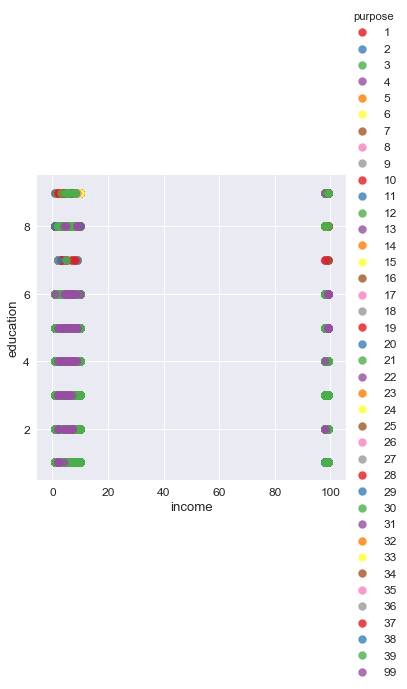

In [80]:
#See if two factors have a linear relationship

sns.lmplot("income", "education", data=df_concat, hue='purpose',
       palette="Set1", fit_reg=False, scatter_kws={"s":70})

In [87]:
#Break up data into X (data) and y (target)

#make a final copy of the data
trips = data.copy(deep=True)

#get the targets (y)
y = trips['purpose']
y.head()


0     4
1     9
2    11
3     1
4     1
Name: purpose, dtype: int64

In [85]:
#make one with less features so less likely to overfit
simple_trips = trips[['gender', 'education','income',
                    'arrival_hour','travel_day_of_week']]
simple_trips

,gender,education,income,arrival_hour,travel_day_of_week
0,1,5,10.0,8,5
1,1,5,10.0,8,5
2,1,5,10.0,11,5
3,1,5,10.0,15,5
4,1,5,10.0,5,5
5,1,5,10.0,7,5
6,2,6,10.0,3,5
7,2,6,10.0,7,5
8,2,6,10.0,8,5
9,1,1,7.0,3,4


In [89]:
# Data (X)

# Have to drop purpose to get X

# all features
trips_minus_purpose = trips.drop(columns=['purpose'])
X = trips_minus_purpose.copy(deep=True)

#simple features
#simple_trips_minus_purpose = simple_trips.drop(columns=['purpose'])
X_simple = simple_trips.copy(deep=True)

#test that X and Y are the same length
print(X.shape)
print(y.shape)

print(X_simple.shape)
print(y.shape)

(430803, 31)
(430803,)
(430803, 5)
(430803,)


In [90]:
# D. Fit the Model (Using Train/Test Split)

# D.a ~~~~~~~~~~~~~~ Train/Test split ~~~~~~~~~~~~~~~

# Step 1: Split X and y into training and test **
from sklearn.model_selection import train_test_split

#on all features
X_train, X_test, y_train, y_test = train_test_split(X , y,
                                                    test_size = 0.3, random_state = 4)

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple , 
                                                                                y, test_size = 0.3, random_state = 4)


In [91]:
# Make sure training data is of the same length
print(X_train.shape)
print(y_train.shape)
print(X_train_simple.shape)
print(y_train_simple.shape)


# Make sure training data is of the same length
print(X_test.shape)
print(y_test.shape)
print(X_test_simple.shape)
print(y_test_simple.shape)


(301562, 31)
(301562,)
(301562, 5)
(301562,)
(129241, 31)
(129241,)
(129241, 5)
(129241,)
